# Tile Coding
---

Tile coding is an innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tilings_; then for any given sample value, you need only check which tiles it lies in. You can then encode the original continuous value by a vector of integer indices or bits that identifies each activated tile.

### 1. Import the Necessary Packages

In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's begin with an environment that has a continuous state space, but a discrete action space.

In [2]:
# Create an environment
env = gym.make('Acrobot-v1')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space: Box(6,)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [ 1.     1.     1.     1.    12.566 28.274]
Action space: Discrete(3)


Note that the state space is multi-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final two dimensions have a larger range. How do we discretize such a space using tiles?

### 3. Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, `bins = (10, 10)`, and `offsets = (-0.1, 0.5)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [3]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.1) => [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7]
    [-5.0, 5.0] / 10 + (0.5) => [-3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

You can now use this function to define a set of tilings that are a little offset from each other.

In [4]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]


It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

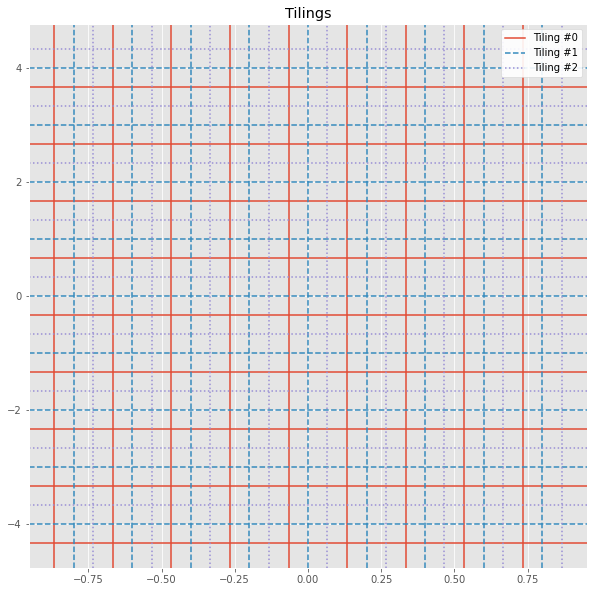

In [5]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


visualize_tilings(tilings);

#### 4. Tile Encoding

Encoding function that will convert any given continuous state value to a discrete vector.

In [6]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """    
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample


# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]
